In [9]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm

SUBJECT_LIST = [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]
PERTURB_AMOUNTS = np.arange(-10, 11) # -10 to 10, just to push the limits
# PERTURB_AMOUNTS = np.arange(-4, 5) # -4 to 4, more biologically realistic
BASELINE = 1
STRESS = 2


def load_dict_from_pickle(file_path):
    ''' Load a dictionary from a pickle file. '''
    try:
        with open(file_path, 'rb') as f:
            loaded_dict = pickle.load(f)
        return loaded_dict
    except Exception as e:
        print("Error:", e)
    return None


def remove_features(feature_dict, features_to_remove):
    '''
    Given a dictionary and a named list of features to remove, 
    create and return a new dictionary with those features removed.
    '''
    # Get indices of features to remove
    remove_feature_indices = np.where(np.isin(feature_dict['feature_names'], features_to_remove))
    
    # Remove them
    features = np.delete(feature_dict['features'], remove_feature_indices, axis=1)
    feature_names = np.delete(feature_dict['feature_names'], remove_feature_indices)
    
    # Create a new dict with the features removed
    new_feature_dict = {'features': features, 'feature_names': feature_names, 'labels': feature_dict['labels'], 'subject': feature_dict['subject']}
    return new_feature_dict


def train_test_split_LOOCV_binary(feature_dict, test_subject):
    '''
    Given the feature_dict containing features for all of the subjects, 
    and the subject to leave out (test_subject), splits the data 
    into train and test data for Leave One Out Cross-Validation (LOOCV).
    
    Also removes the amusement condition (labels == 3) to make this a binary classification problem.
    
    Returns:
    X_train, X_test, y_train, y_test (train data, test data, train labels, test labels)
    '''
    
    features = feature_dict['features']
    labels = feature_dict['labels']
    train_indices = np.where((np.array(feature_dict['subject']) != test_subject) & (labels != 3))[0]
    test_indices = np.where((np.array(feature_dict['subject']) == test_subject) & (labels != 3))[0]
    
    # Yell at us if there is any overlap, just in case
    if np.any(np.isin(train_indices, test_indices)):
        print("NO! Train and test overlap!!!!!!")
        
    return features[train_indices], features[test_indices], labels[train_indices], labels[test_indices]


def perturb_feature_by_amount(array, column_index, amount):
    ''' Given a feature array, returns a new array perturbed at the given index by the given amount.'''
    perturbed_array = array.copy()
    perturbed_array[:, column_index] += amount
    return perturbed_array

In [ ]:
# Load data
file_path_zscored_by_sub = f"features/combined/feature_dict_zscored_by_sub.pkl"
feature_dict = load_dict_from_pickle(file_path_zscored_by_sub)

# Features to remove in the first pass based on domain knowledge and correlations.
features_to_remove_1 = ['ACC x mean', 'ACC y mean', 'ACC z mean', 'ACC mean', 'ACC x std', 'ACC y std',
                    'ACC z std', 'ACC std', 'ACC abs integral x', 'ACC abs integral y', 'ACC abs integral z',
                    'ACC peak frequency x', 'ACC peak frequency y', 'ACC peak frequency z', 
                    'EMG dynamic range', 'EMG absolute integral','EMG 10th percentile', 'EMG 90th percentile','EMG peak frequency', 'EMG std peak amplitude', 
                    'EMG sum peak amplitudes', 'EMG normalized sum peak amplitudes', 'Respiration duration',
                    'Temp min', 'Temp max', 'Temp dynamic range', 'EDA std', 'EDA min', 'EDA max', 'EDA dynamic range', 
                    'Sum of response durations', 'HRV mean', 'HRV RMS', 'nn50', 'pnn50', 'ECG HF energy']

# Features to remove in the second pass based on importance for the final classification.
features_to_remove_2 = ['EMG mean', 'EMG # peaks', 'Mean inhale duration', 'Std exhale duration', 'Respiration range',
                       'Respiration rate', 'Respiration volume', 'Temp mean', 'Temp std', 'Temp slope', 'SCR/SCL mean',
                       'SCR/SCL std', 'SCL time corr', 'HR std']

# Remove features
feature_dict = remove_features(feature_dict, features_to_remove_1)
#feature_dict = remove_features(feature_dict, features_to_remove_2)

### Investigate how perturbing a given feature changes our predictions

Works for any model!
Just edit the line model = .... with the model of your choice

  0%|                                                    | 0/28 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  3.07it/s]
2it [00:00,  3.01it/s]
3it [00:00,  3.00it/s]
4it [00:01,  3.00it/s]
5it [00:01,  3.00it/s]
6it [00:02,  2.98it/s]
7it [00:02,  2.98it/s]
8it [00:02,  2.98it/s]
9it [00:03,  2.98it/s]
10it [00:03,  2.99it/s]
11it [00:03,  2.99it/s]
12it [00:04,  2.99it/s]
13it [00:04,  2.98it/s]
14it [00:04,  2.96it/s]
15it [00:05,  2.98it/s]
  4%|█▌                                          | 1/28 [00:05<02:15,  5.03s/it]
0it [00:00, ?it/s]
1it [00:00,  3.00it/s]
2it [00:00,  3.00it/s]
3it [00:01,  2.98it/s]
4it [00:01,  2.98it/s]
5it [00:01,  2.97it/s]
6it [00:02,  2.98it/s]
7it [00:02,  2.98it/s]
8it [00:02,  2.98it/s]
9it [00:03,  2.94it/s]
10it [00:03,  2.94it/s]
11it [00:03,  2.96it/s]
12it [00:04,  2.97it/s]
13it [00:04,  2.98it/s]
14it [00:04,  2.98it/s]
15it [00:05,  2.97it/s]
  7%|███▏                                        | 2/28 [00:10<02:11,  5.04s/it]
0it [00:00, ?it/s

5it [00:01,  2.84it/s]
6it [00:02,  2.86it/s]
7it [00:02,  2.88it/s]
8it [00:02,  2.89it/s]
9it [00:03,  2.87it/s]
10it [00:03,  2.87it/s]
11it [00:03,  2.89it/s]
12it [00:04,  2.88it/s]
13it [00:04,  2.88it/s]
14it [00:04,  2.89it/s]
15it [00:05,  2.87it/s]
 61%|██████████████████████████                 | 17/28 [01:27<00:57,  5.24s/it]
0it [00:00, ?it/s]
1it [00:00,  2.88it/s]
2it [00:00,  2.92it/s]
3it [00:01,  2.88it/s]
4it [00:01,  2.85it/s]
5it [00:01,  2.85it/s]
6it [00:02,  2.87it/s]
7it [00:02,  2.85it/s]
8it [00:02,  2.85it/s]
9it [00:03,  2.85it/s]
10it [00:03,  2.87it/s]
11it [00:03,  2.88it/s]
12it [00:04,  2.90it/s]
13it [00:04,  2.89it/s]
14it [00:04,  2.76it/s]
15it [00:05,  2.84it/s]
 64%|███████████████████████████▋               | 18/28 [01:32<00:52,  5.25s/it]
0it [00:00, ?it/s]
1it [00:00,  2.94it/s]
2it [00:00,  2.91it/s]
3it [00:01,  2.87it/s]
4it [00:01,  2.86it/s]
5it [00:01,  2.85it/s]
6it [00:02,  2.85it/s]
7it [00:02,  2.88it/s]
8it [00:02,  2.88it/s]
9it [0

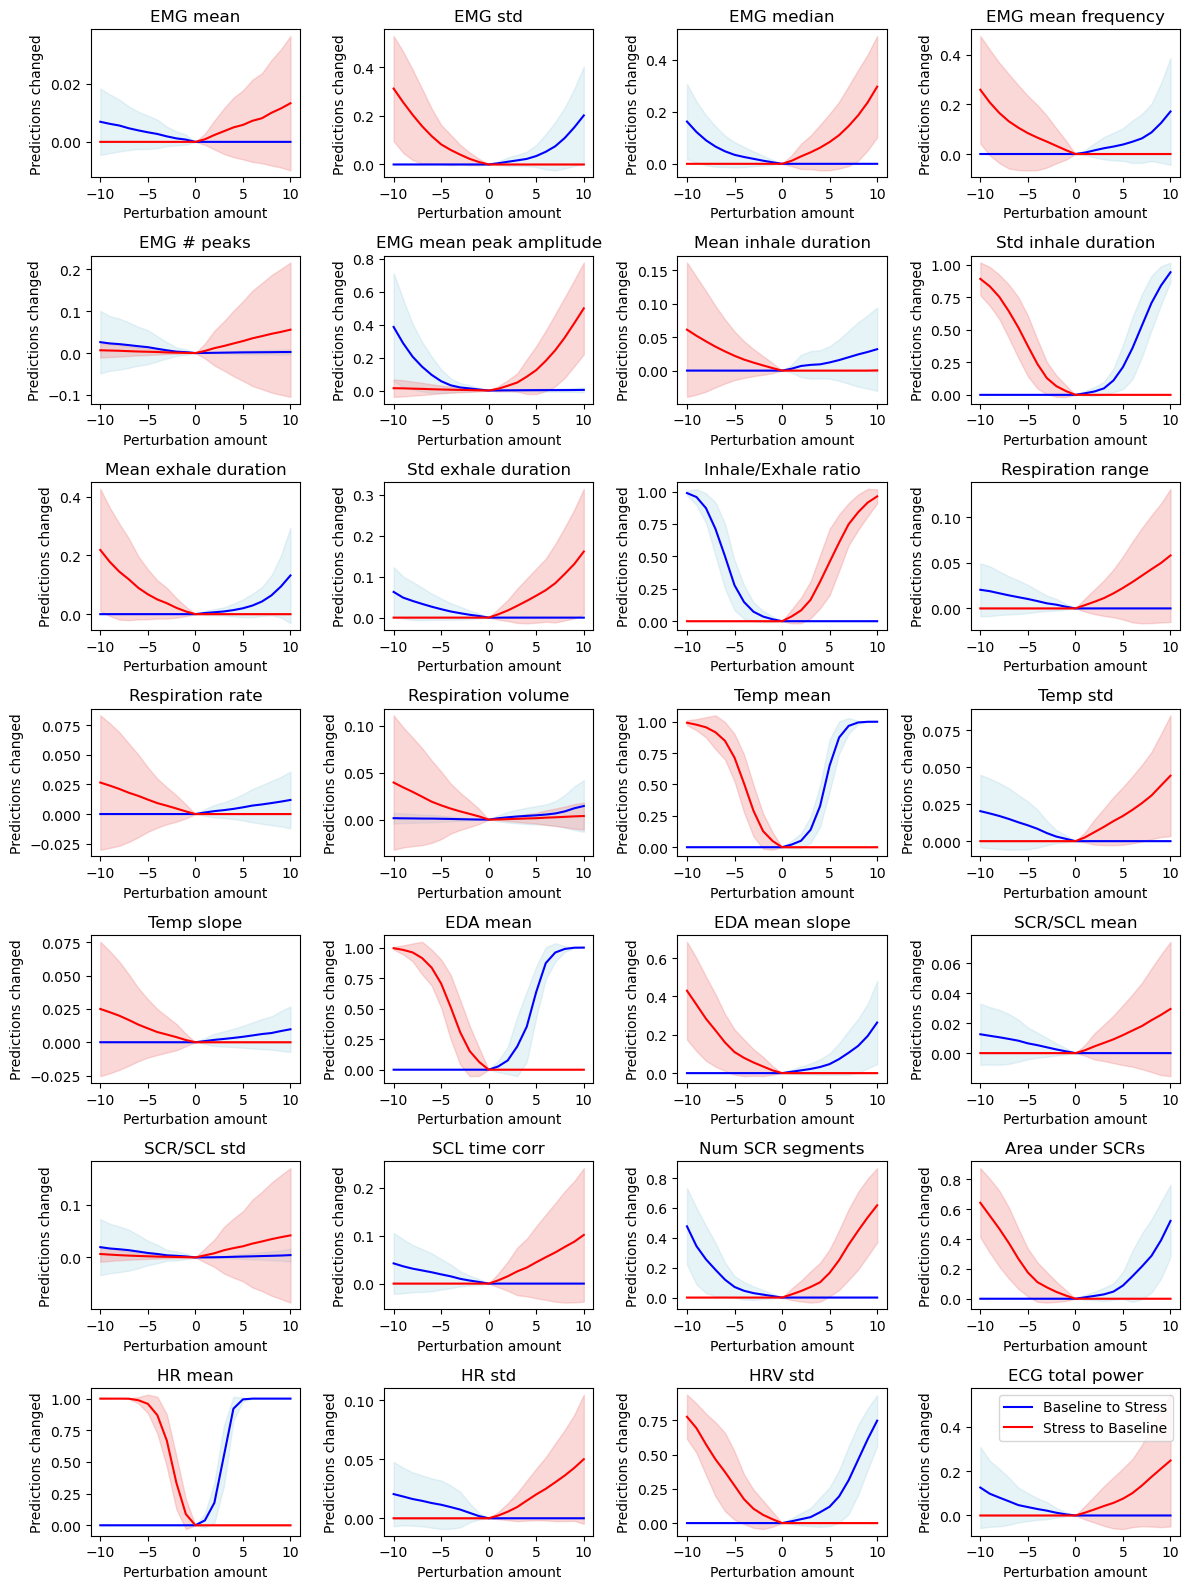

In [18]:
# Pick a model to investigate
model = LinearDiscriminantAnalysis()
# model = MLPClassifier(hidden_layer_sizes=(32,), activation='relu', solver='adam', random_state=42)
# model = model of your choice! 

# Create 28 subplots for the 28 features we are investigating
fig, axs = plt.subplots(7, 4, figsize=(12, 16))
axs = axs.flatten()

# Loop through all features, investigating the effect of perturbing each one and adding to the plot
for feature_to_perturb in tqdm(np.arange(28)):
    feature_name = feature_dict['feature_names'][feature_to_perturb]

    pred_changed_base_to_stress = np.zeros((len(PERTURB_AMOUNTS), len(SUBJECT_LIST)))
    pred_changed_stress_to_base = np.zeros((len(PERTURB_AMOUNTS), len(SUBJECT_LIST)))
    
    # Do this for all test subjects (LOOCV)
    for s, test_sub in tqdm(enumerate(SUBJECT_LIST)):
        # Split the data into training and testing sets by subject
        X_train, X_test, y_train, y_test = train_test_split_LOOCV_binary(feature_dict, test_sub)
    
        # Fit the model using training data
        model.fit(X_train, y_train)

        # Make predictions on the original test data
        y_pred = model.predict(X_test)
    
        for i, perturb_amount in enumerate(PERTURB_AMOUNTS):
            # Make predictions on the perturbed test data
            perturbed_X_test = perturb_feature_by_amount(X_test, feature_to_perturb, perturb_amount)
            perturbed_y_pred = model.predict(perturbed_X_test)
            # If (perturbed - regular) = 1, we went baseline to stress; if -1 we went stress to baseline
            pred_diffs = perturbed_y_pred - y_pred
            # Normalize by the number of predictions originally in that category
            pred_changed_base_to_stress[i, s] = np.count_nonzero(pred_diffs == 1)/np.count_nonzero(y_pred == BASELINE)
            pred_changed_stress_to_base[i, s] = np.count_nonzero(pred_diffs == -1)/np.count_nonzero(y_pred == STRESS)

    # Report mean and std across all subjects
    mean_base2stress = np.mean(pred_changed_base_to_stress, axis=1)
    std_base2stress = np.std(pred_changed_base_to_stress, axis=1)
    mean_stress2base = np.mean(pred_changed_stress_to_base, axis=1)
    std_stress2base = np.std(pred_changed_stress_to_base, axis=1)

    # Plot baseline to stress and stress to baseline. Shade area around mean to show standard deviation
    f = feature_to_perturb
    axs[f].plot(PERTURB_AMOUNTS, mean_base2stress, color='blue', label='Baseline to Stress')
    axs[f].fill_between(PERTURB_AMOUNTS, mean_base2stress - std_base2stress, mean_base2stress + std_base2stress, color='lightblue', alpha=0.3)
    axs[f].plot(PERTURB_AMOUNTS, mean_stress2base, color='red', label='Stress to Baseline')
    axs[f].fill_between(PERTURB_AMOUNTS, mean_stress2base - std_stress2base, mean_stress2base + std_stress2base, color='lightcoral', alpha=0.3)
    axs[f].set_title(feature_name)
    axs[f].set_xlabel("Perturbation amount")
    axs[f].set_ylabel("Predictions changed")

plt.tight_layout()
plt.legend()
plt.show()

### Now investigate interactions by perturbing different combinations of features

TODO: Figure out a good subset of this to do / make it less computationally intensive so my kernel doesn't die immediately

In [ ]:
def perturb_all_feature_combos(array, amount):
    """
    Generate every possible combination of perturbations for every index of an array by a single amount.

    Returns a tuple containing:
    - An array of perturbed arrays, each representing a unique perturbation combination.
    - A list of indices where perturbations occurred.
    """
    original_array = array.copy()
    # Generate perturbation combinations for each index
    perturbation_combos = list(product([0, amount], repeat=len(original_array)))

    # Generate all possible perturbed arrays and keep track of perturbed indices
    perturbed_arrays = []
    perturbed_indices = []
    for combo in tqdm(perturbation_combos):
        perturbed_array = original_array + np.array(combo)
        perturbed_arrays.append(perturbed_array)
        perturbed_index = [i for i, (a, b) in enumerate(zip(original_array, perturbed_array)) if a != b]
        perturbed_indices.append(perturbed_index)

    return perturbed_arrays, perturbed_indices

# Test that this function works
original_array = np.array([0, 0, 0, 0])
amount = 2

# Generate every possible combination of perturbations for every index by the single amount
all_index_perturbations, perturbed_indices = perturb_all_feature_combos(original_array, amount)

# Print the resulting outputs
for perturbed_array in all_index_perturbations:
    print(perturbed_array)
    
print(perturbed_indices)

In [ ]:
# Investigate how perturbing combinations of feature changes our predictions.

#pred_changed_base_to_stress = np.zeros((len(PERTURB_AMOUNTS), len(SUBJECT_LIST)))
#pred_changed_stress_to_base = np.zeros((len(PERTURB_AMOUNTS), len(SUBJECT_LIST)))
    
# Do this for all test subjects (LOOCV)
#for s, test_sub in tqdm(enumerate(SUBJECT_LIST)):
test_sub = 2
perturb_amount = 1
    
# Split the data into training and testing sets by subject
X_train, X_test, y_train, y_test = train_test_split_LOOCV_binary(feature_dict, test_sub)
    
# Fit the model using training data
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)

# Make predictions on the original test data
y_pred = model.predict(X_test)

# Make predictions on the perturbed test data
perturbed_X_test, perturbed_indices = perturb_all_feature_combos(X_test, perturb_amount)
perturbed_y_pred = model.predict(perturbed_X_test)

# # If (perturbed - regular) = 1, we went baseline to stress; if -1 we went stress to baseline
# pred_diffs = perturbed_y_pred - y_pred
# # Normalize by the number of predictions originally in that category
# pred_changed_base_to_stress[i, s] = np.count_nonzero(pred_diffs == 1)/np.count_nonzero(y_pred == BASELINE)
# pred_changed_stress_to_base[i, s] = np.count_nonzero(pred_diffs == -1)/np.count_nonzero(y_pred == STRESS)

# # Report mean and std across all subjects
# mean_base2stress = np.mean(pred_changed_base_to_stress, axis=1)
# std_base2stress = np.std(pred_changed_base_to_stress, axis=1)
# mean_stress2base = np.mean(pred_changed_stress_to_base, axis=1)
# std_stress2base = np.std(pred_changed_stress_to_base, axis=1)

# plt.tight_layout()
# plt.show()